In [1]:
using GRAPE
using QuantumControl
using LinearAlgebra
using QuantumPropagators: ExpProp
using Random

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
# using Optimization, OptimizationOptimisers
using JSON
# using OptimizationOptimJL
# using ExponentialUtilities

QuantumControl.set_default_ad_framework(Zygote)

using QuantumControl.Functionals: make_chi, J_T_sm
using QuantumControl.Controls: get_controls, substitute

include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

┌ Info: QuantumControl: Setting Zygote as the default provider for automatic differentiation.
└ @ QuantumControl.Functionals /home/jek354/.julia/packages/QuantumControl/51awt/src/functionals.jl:298


append_to_json_files (generic function with 1 method)

In [2]:


function create_fermionic_hamiltonian(subspace, indexer)

    time_dep_perturb = []
    dim = get_subspace_dimension(subspace)
    i = 0

    # single body interactions
    for σ1 in 1:2
        for σ2 in 1:2
            for s1 in indexer.a
                for s2 in neighbors(subspace.lattice,s1)
                    if s1 > s2 #don't double count
                        continue
                    end
                    i += 1
                    
                    t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
                    t_dict[[(s1, σ1,:create), (s2, σ2, :annihilate)]] = 1
                    rows = Int[]
                    cols = Int[]
                    vals = Float64[]
                    general_n_body!(rows, cols, vals, t_dict, indexer)
                    tmp_h = Hermitian(sparse(rows, cols, vals, dim, dim))
                    @eval $(Symbol("a$i"))(t) = 1.0
                    push!(time_dep_perturb, (tmp_h, @eval $(Symbol("a$i"))))
                end
            end
        end
    end
    return hamiltonian(spzeros(dim, dim), time_dep_perturb...)
end

half_filling = false
bc = "periodic"
N = 2
lattice_dimension = (2,1)
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
subspace = HubbardSubspace(N, lattice)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
H = create_fermionic_hamiltonian(subspace, indexer)
get_controls(H)

┌ Warning: Collected operators are not of a concrete type: AbstractMatrix{Float64}
└ @ QuantumPropagators.Generators /home/jek354/.julia/packages/QuantumPropagators/0hpPp/src/generators.jl:397


(Main.a1, Main.a2, Main.a3, Main.a4, Main.a5, Main.a6, Main.a7, Main.a8, Main.a9, Main.a10, Main.a11, Main.a12, Main.a13, Main.a14, Main.a15, Main.a16, Main.a17, Main.a18, Main.a19, Main.a20, Main.a21, Main.a22, Main.a23, Main.a24, Main.a25, Main.a26, Main.a27, Main.a28, Main.a29, Main.a30, Main.a31, Main.a32, Main.a33, Main.a34, Main.a35, Main.a36, Main.a37, Main.a38, Main.a39, Main.a40, Main.a41, Main.a42, Main.a43, Main.a44, Main.a45, Main.a46, Main.a47, Main.a48)

In [ ]:


dim = get_subspace_dimension(subspace)
Nt = 499
tlist = collect(range(0, 5, length=Nt+1));

function ket(k, dim)
    state = zeros(ComplexF64, dim)
    state[k] = 1
    state
end
function J_a(pulsevals::Vector{Float64}, tlist)
    dt = tlist[2] - tlist[1]
    # println(pulsevals)
    # println(norm(pulsevals,1))
    norm(pulsevals, 1)*dt
end

trajectories = [Trajectory(initial_state=ket(1, dim), generator=H, target_state=ket(2, dim))];
chi_sm = make_chi(J_T_sm, trajectories; mode=:automatic, automatic=Zygote)

problem = ControlProblem(
    trajectories=trajectories,
    tlist=tlist,
    iter_stop=50,
    prop_method=ExpProp,
    pulse_options=Dict(),
    J_T=J_T_sm,
    J_a=J_a,
    lambda_a = 1e-5,
    # upper_bounds = (fill( 0.30, Nt), fill( 0.30, Nt)),  # example amplitude box
    # lower_bounds = (fill(-0.30, Nt), fill(-0.30, Nt)),
    # info_hook = GRAPE.make_grape_print_iters()   
);

result = optimize(problem; method=GRAPE)

In [42]:
result.optimized_controls

1-element Vector{Vector{Float64}}:
 [0.9424767960771037, 0.9424767960771037, 0.9424767960771037, 0.9424767960771038, 0.9424767960771037, 0.9424767960771037, 0.9424767960771038, 0.9424767960771038, 0.9424767960771039, 0.9424767960771039  …  0.9424767960770907, 0.9424767960770908, 0.9424767960770907, 0.9424767960770906, 0.9424767960770903, 0.9424767960770927, 0.9424767960770928, 0.9424767960770905, 0.9424767960770905, 0.9424767960770905]

4-element Vector{Vector{Float64}}:
 [3.2339313012305888e-12, 2.7588401821609596e-12, 1.9160422183043773e-12, 5.239041887429768e-13, -9.521148889422335e-13, -1.8708791068270408e-12, -2.56923953601982e-12, -3.5500054578198278e-12, -4.7175484253870496e-12, -5.898735671709425e-12  …  -4.82936461305034e-11, -4.646950454235345e-11, -4.460473116281536e-11, -4.3624497498214946e-11, -4.2080665455657585e-11, -4.024154452940954e-11, -3.906457386534493e-11, -3.729223492223297e-11, -3.544338417040761e-11, -3.481333473576187e-11]
 [1.099556922863309, 1.099556922863291, 1.0995569228630506, 1.0995569228629818, 1.099556922863281, 1.0995569228626456, 1.0995569228621624, 1.099556922862703, 1.099556922862257, 1.0995569228615636  …  1.0995569220128187, 1.0995569220117227, 1.0995569220110895, 1.0995569220110892, 1.0995569220104549, 1.0995569220116646, 1.0995569220132047, 1.0995569220132433, 1.0995569220133188, 1.0995569220133574]
 [1.099556922863309, 1.099556922863291, 1.0995569228630506, 1.0995569228629818

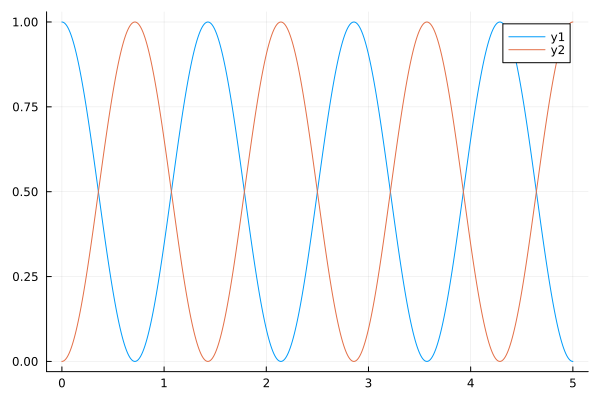

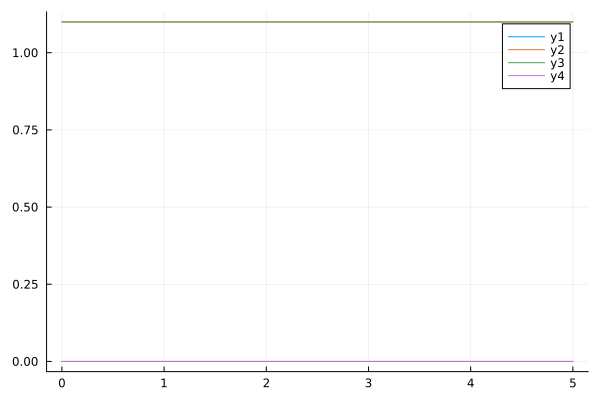

In [54]:
using Plots
using QuantumControl.Controls: substitute
opt_dynamics = propagate_trajectory(
    substitute(trajectories[1], IdDict(zip(get_controls(trajectories), result.optimized_controls))),
    problem.tlist,
    method=ExpProp,
    storage=true,
    observables=(Ψ -> abs.(Ψ) .^ 2,)
)
display(result.optimized_controls)
p = plot()
for i in 1:2
    plot!(p, tlist, opt_dynamics[i, :])
end
display(p)

p = plot()
for i in 1:length(get_controls(trajectories))
    plot!(p, tlist, result.optimized_controls[i])
end
display(p)